In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
%matplotlib inline

In [2]:
dict_genres = {'Blues':0, 'Classical':1, 'Country':2, 'Disco':3, 'Hip-Hop':4, 'Jazz':5, 'Metal':6, 'Pop':7, 'Reggae':8, 'Rock':9}

In [3]:
def create_spectogram(audio_path):
    y, sr = librosa.load(audio_path)
    spect = librosa.feature.melspectrogram(y=y, sr=sr)
    spect = librosa.power_to_db(spect, ref=np.max)
    return spect.T

In [4]:
def create_array():
    genres = []
    X_spect = np.empty((0, 1280, 128))
    count = 0
    for g in list(dict_genres.keys()):
        #Code skips records in case of errors
        print(g)
        for filename in os.listdir(os.path.join('data/genres_original/',f'{g}')):
            try:
                count += 1
                audio_path = os.path.join(f'data/genres_original/{g}',f'{filename}')
                spect = create_spectogram(audio_path)

                # Normalize for small shape differences
                spect = spect[:1280, :]
                X_spect = np.append(X_spect, [spect], axis=0)
                genres.append(dict_genres[g])
                if count % 100 == 0:
                    print("Currently processing: ", count)
            except:
                print("Couldn't process: ", count)
                continue
    y_arr = np.array(genres)
    return X_spect, y_arr

In [5]:
def plot_spect(audio_path):
    spect = create_spectogram(audio_path)
    print(spect.shape)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

(1293, 128)


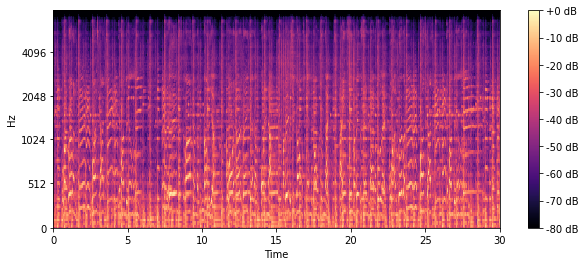

In [6]:
plot_spect('data/genres_original/Blues/blues.00000.wav')

In [7]:
X_data, y_data = create_array()

Blues
Currently processing:  100
Classical
Currently processing:  200
Country
Currently processing:  300
Disco
Currently processing:  400
Hip-Hop
Currently processing:  500
Jazz


C:\Users\Gabriele\anaconda3\envs\music-genre-recognition\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Couldn't process:  555
Currently processing:  600
Metal
Currently processing:  700
Pop
Currently processing:  800
Reggae
Currently processing:  900
Rock
Currently processing:  1000


In [8]:
print(X_data.shape, y_data.shape)

(999, 1280, 128) (999,)


In [9]:
np.savez('data/all_targets_sets', X_data, y_data)